# Timeseries module - demo

`pynsitu.tseries` implements methods useful to the time series analysis

Assumptions about the data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import pynsitu as pin

/Users/aponte/Code/pynsitu/pynsitu/tseries.py:926: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if "alpha" is not None:


---

## generate synthetic time series


In [2]:
tdefault = dict(start="2018-01-01", end="2018-01-30", freq="1H")


def generate_time_series(label="time", uniform=True, time_units="datetime"):
    """Create a drifter time series."""
    time = pd.date_range(**tdefault)
    time_scale = pd.Timedelta("1D")
    if time_units == "timedelta":
        time = time - time[0]
    elif time_units == "numeric":
        time = (time - time[0]) / pd.Timedelta("1H")
        time_scale = 1.0
    if not uniform:
        nt = time.size
        import random

        time = time[random.sample(range(nt), 2 * nt // 3)].sort_values()
    #
    v0 = (
        np.cos(2 * np.pi * ((time - time[0]) / time_scale))
        + np.random.randn(time.size) / 2
    )
    v1 = (
        np.sin(2 * np.pi * ((time - time[0]) / time_scale))
        + np.random.randn(time.size) / 2
    )
    df = pd.DataFrame({"v0": v0, "v1": v1, label: time})
    df = df.set_index(label)
    return df

In [3]:
# actually generate one time series
df = generate_time_series(uniform=False)
df

,v0,v1
time,,
2018-01-01 01:00:00,-0.129345,0.883350
2018-01-01 02:00:00,0.386554,0.119373
2018-01-01 03:00:00,1.086303,0.055039
2018-01-01 04:00:00,0.426578,-0.218319
2018-01-01 06:00:00,0.234288,0.107355
...,...,...
2018-01-29 19:00:00,0.464309,-1.303498
2018-01-29 20:00:00,0.739744,-1.141437
2018-01-29 21:00:00,-0.331088,-0.210606


<Axes: xlabel='time'>

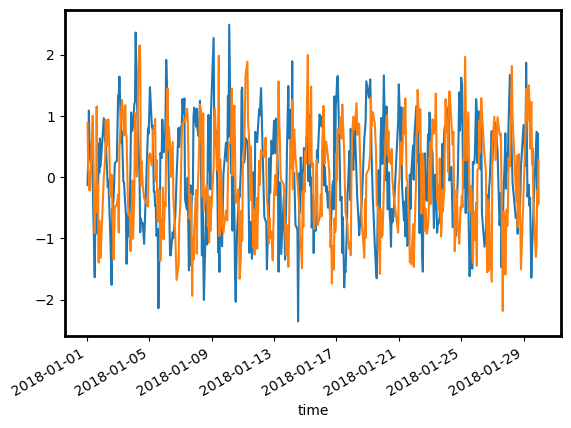

In [4]:
df.v0.plot()
df.v1.plot()

---

## basic editing

### triming based on deployment information

<Axes: xlabel='time'>

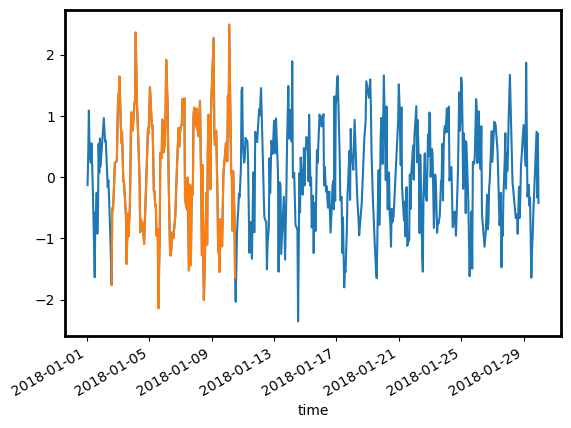

In [5]:
d = pin.events.Deployment(
    "some_event",
    start="2018/01/02 12:12:00",
    end="2018/01/10 12:12:00",
)

df_trimmed = df.ts.trim(d)

df.v0.plot()
df_trimmed.v0.plot()

### resampling on a regular timeline

In [6]:
df_resampled = df.ts.resample_uniform("1H")

(17532.625, 17533.916666666668)

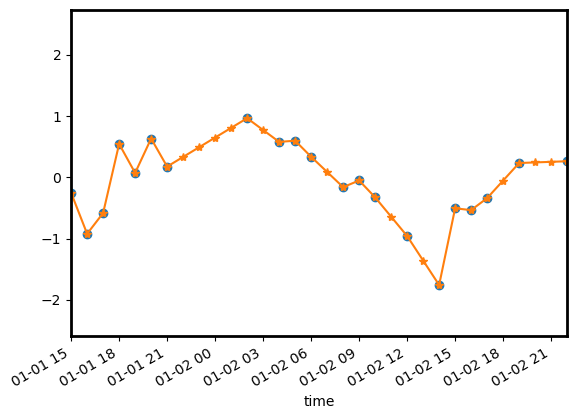

In [7]:
fig, ax = plt.subplots(1, 1)
df.v0.plot(marker="o", ls="None")
df_resampled.v0.plot(marker="*")
ax.set_xlim(df.index[10], df.index[30])

---
## spectral analysis

In [8]:
E = df_resampled.ts.spectrum(nperseg=24 * 5)
E

,v0,v1
frequency,,
-0.000139,311.302139,407.462637
-0.000137,458.895948,321.174409
-0.000134,470.418444,225.005958
-0.000132,353.168037,241.211823
-0.000130,284.745741,220.329246
...,...,...
0.000127,279.757063,360.451258
0.000130,284.745741,220.329246
0.000132,353.168037,241.211823


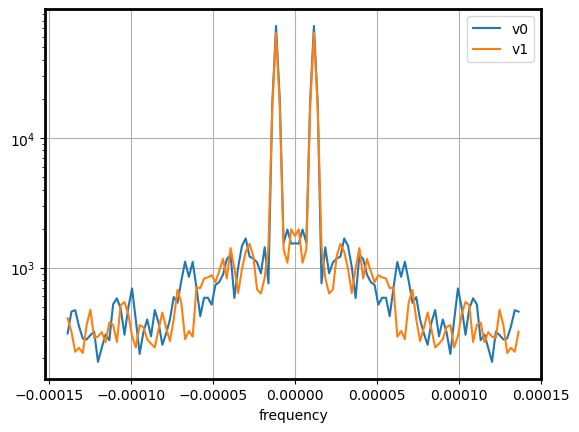

In [9]:
E.plot()
plt.yscale("log")
plt.grid()

### rotary spectrum

Compute the spectrum of `v0 + 1j v1`

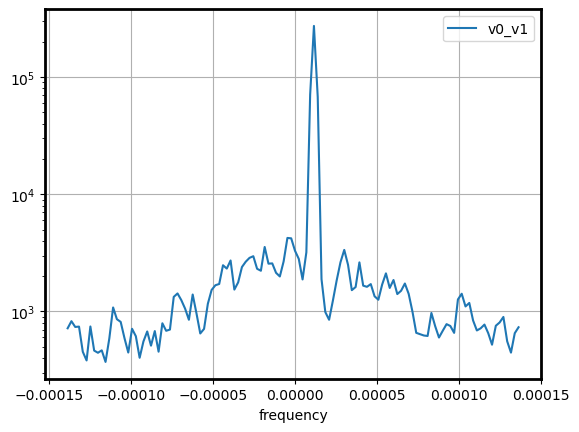

In [10]:
E = df_resampled.ts.spectrum(nperseg=24 * 5, complex=("v0", "v1"))
E.plot()
plt.yscale("log")
plt.grid()

---
## filtering

to be done ...

---
## tidal analysis

to be done ...

---
## with xarray objects

In [11]:
ds = df_resampled.to_xarray().expand_dims(x=range(10)).chunk(dict(x=2))
ds

<xarray.Dataset>
Dimensions:  (x: 10, time: 695)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9
  * time     (time) datetime64[ns] 2018-01-01T01:00:00 ... 2018-01-29T23:00:00
Data variables:
    v0       (x, time) float64 dask.array<chunksize=(2, 695), meta=np.ndarray>
    v1       (x, time) float64 dask.array<chunksize=(2, 695), meta=np.ndarray>

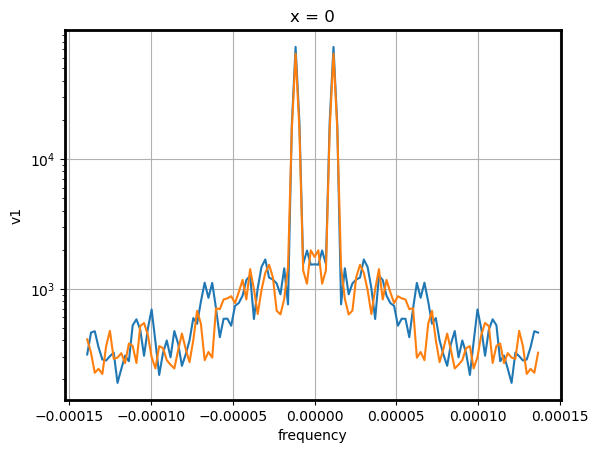

In [12]:
E = ds.ts.spectrum(nperseg=24 * 5)
E.v0.isel(x=0).plot()
E.v1.isel(x=0).plot()
plt.yscale("log")
plt.grid()